[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/17_Diffusion.ipynb)

# Diffusion Models

*...for people who are uncomfortable with probability math.* 

--Scott H. Hawley

*Feb 4, 2004: This is a Work In Progress!*

---

Most tutorials on diffusion models go like this: "Here's the basic idea. Now here's a wall of math. Finally let's code it." 

We will try to skip as much as we can from that wall of math.  (Hint to other instructors: Nobody's gonna read your wall of math!) However, it turns out that if you *don't* include at least they key results from the math, you won't get *any* intelligible outputs. In other words, just coding up something based on "the basic idea" will result in failure -- I tried -- so we'll need a few equations eventually to make it work.  

## Outline: 
1. Setting Up
1. The Idea: Adding Noise
1. The DDPM Model
1. Train the DDPM Model
1. Inference, aka Sampling
1. Enhancements: Conditioning ("CFG") + EMA + Cosine Noise Schedule
1. Appendix: Diffusion Models a Based in Physics! (TODO)

## References:
- [This YouTube Video](https://youtu.be/TBCRlnwJtZU?si=LGlT96dp6Y5zwRtb) is awesomely comprehensive in only 20 minutes!

# 1. Setup

## Setup Imports

In [1]:
# we'll use pytorch lightning as an alternative to raw pytorch
!pip install -Uqq lightning wandb einops

In [2]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.loggers import WandbLogger
import wandb
import numpy as np
from einops import rearrange
from tqdm.notebook import trange, tqdm
import os

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [4]:
use_wandb=True
if use_wandb: 
    !pkill -f wandb
    wandb.login()

wandb: Currently logged in as: drscotthawley (strange-quarks). Use `wandb login --relogin` to force relogin


## Setup Dataset

MNIST is small and easy and you can do it on a CPU. Let's keep everything super-simple at first: black & white images.

In [5]:
imsize = 32 # 28 # resize from 28 to 32 b/c 32 divides more

transform01 = torchvision.transforms.Compose([
        torchvision.transforms.Resize(imsize),  
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])

train_ds = MNIST(root='./data', train=True,  download=True, transform=transform01)
test_ds  = MNIST(root='./data', train=False, download=True, transform=transform01)
val_ds = test_ds  #alias val & test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")

Data set lengths: train: 60000, test: 10000


Inspect it a bit..

y (target) = 5 
x.shape = (32, 32), min(x) = -1.0, max(x) = 0.9843137264251709


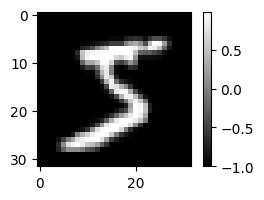

In [6]:
x, y = train_ds[0]   # pick an element
print(f"y (target) = {y} ")

def show_xs(xs, show_stats=True):
    "A little utility we'll call again & again to show one or more images"
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

show_xs([x])

Define dataloaders

In [7]:
#batch_size = 128
batch_size = 4096
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, shuffle=False)
val_dl = test_dl # alias val & test

# 2. The Idea: Cross-Fading (to Noise)

I'm going to explain this a bit differently than one sees in many other treatments. But my way is easier and is isomorphic to the other presentations:

We're going to cross-fade from our signal (the image) to pure noise, in such a way that the power stays constant. Here's some funny notation: 

* $\overline{\alpha}_t$ is the "signal power" at any time $t$
* $1 - \overline{\alpha}_t$ is the "noise power"

Adding those two together, you'll see we get a constant power of 1. There are a couple common ways to do this in the audio world.  One is with a linear variation in power and the other follows a cosine shape for the signal power.  In diffusion literature, these are referred to as "noise schedules".  

Here's a picture showing examples of these two schedules (i.e. crossfades), shown in arbitrary time units:

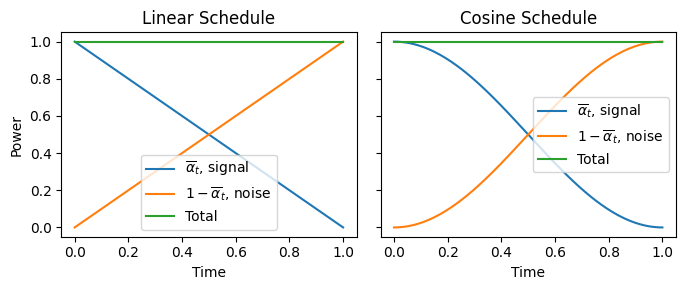

In [409]:
steps = 200
ts = torch.linspace(0,1.0,steps)
lin_sig_power = 1 - ts
cos_sig_power = torch.cos(ts*torch.pi*0.5)**2   # "cosine schedule"

def plot_power_schedules():
    
    fig, axs = plt.subplots(figsize=(7,3), ncols=2, sharey=True, tight_layout=True)
    for i, ax in enumerate(axs):
        if i==0: 
            ax.set_title('Linear Schedule')
            ax.set_ylabel('Power')
            signal_power = lin_sig_power
        else:
            ax.set_title('Cosine Schedule')
            signal_power = cos_sig_power
        noise_power = 1 - signal_power
        ax.plot(ts, signal_power,label=r'$\overline{\alpha}_t$, signal')
        ax.plot(ts, noise_power,label=r'$1-\overline{\alpha}_t$, noise')
        ax.plot(ts, signal_power+noise_power,label='Total')
        ax.legend()
        ax.set_xlabel('Time')
    plt.show()

plot_power_schedules()


But the *values* of the signals we work with are always in terms of *amplitude*, not power, and power is the *square* of the amplitude.  Thus:

* $\sqrt{\overline{\alpha}_t}$ is the signal *amplitude* at any time $t$
* $\sqrt{1 - \overline{\alpha}_t}$ is the noise *amplitude*

Here's a picture of the amplitudes:

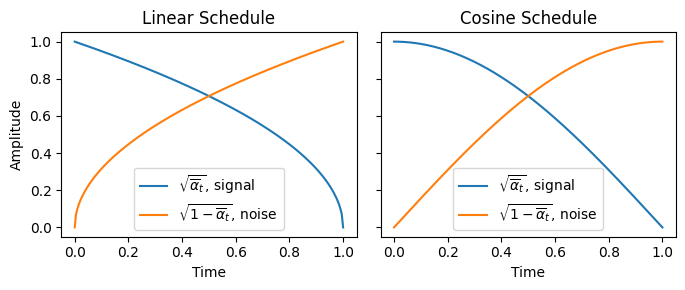

In [412]:
def plot_amp_schedules():
    fig, axs = plt.subplots(figsize=(7,3), ncols=2, sharey=True, tight_layout=True)
    for i, ax in enumerate(axs):
        if i==0: 
            ax.set_title('Linear Schedule')
            ax.set_ylabel('Amplitude')
            sig_power = lin_sig_power
        else:
            ax.set_title('Cosine Schedule')
            sig_power = cos_sig_power        
        noise_power = 1 - sig_power
        
        sig_amp = torch.sqrt(sig_power)
        noise_amp = torch.sqrt(noise_power)
        ax.plot(ts, sig_amp,label=r'$\sqrt{\overline{\alpha}_t}$, signal')
        ax.plot(ts, noise_amp,label=r'$\sqrt{1-\overline{\alpha}_t}$, noise')
        ax.legend()
        ax.set_xlabel('Time')
    plt.show()

plot_amp_schedules()

So using the symbol $x_0$ for the (original/pristine) signal and $\epsilon$ for the noise, our cross-faded image-mix $x_t$ at any time t is given by: 

$$x_t = \sqrt{\overline{\alpha}_t} x_0 + \sqrt{1 - \overline{\alpha}_t} \epsilon $$

Apart from the symbols that's not so bad, right? 

Here's what it looks like in terms of a real image:

       Adding noise as we go to the right --->


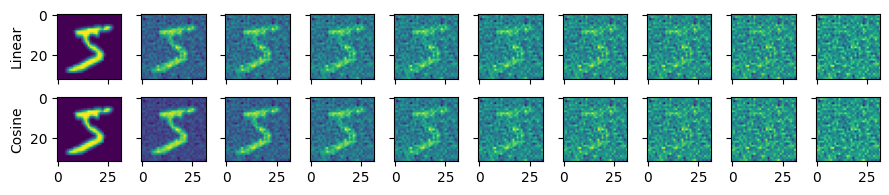

In [437]:
x0 = x[0]
eps = torch.randn_like(x0)
#print('x0.shape = ',x0.shape)

steps = 10
ts = torch.linspace(0,1.0,steps)
lin_sig_power = 1 - ts
cos_sig_power = torch.cos(ts*torch.pi*0.5)**2   # "cosine schedule"

fig, axs = plt.subplots(figsize=(9,2), nrows=2, ncols=steps, sharex=True, sharey=True, tight_layout=True)
for i, sig_power in enumerate([lin_sig_power, cos_sig_power]):
    noise_power = 1.0 - sig_power
    sig_amp = torch.sqrt(sig_power)
    noise_amp = torch.sqrt(noise_power) 
    axs[i,0].set_ylabel(f'{"Linear" if i==0 else "Cosine"}')
    for j in range(steps):
        xt = sig_amp[j] * x0 + noise_amp[j] * eps
        axs[i,j].imshow(xt)
        #axs[i,j].axis('off')

print("       Adding noise as we go to the right --->")
plt.show()

The two rows of images look very similar, and inded the starting and ending images don't depend on the schedule, but the Linear schedule (top row) gets noisier earlier on than the cosine schedule -- compare the second column, for instance. 

....So we will train the model to do that in reverse.


# 3. DDPM 
> The paper: "Denoising Diffusion Probabilistic Models" by [Ho et al, 2020](https://arxiv.org/abs/2006.11239) 

Often explanations of diffusion models immediately jump into the theory of probability distributions, with REALLY BIG equations and symbols like $p_{\theta}(this|that)$ all over the place... it's easy to get lost in the math.  But the code is considerably more tractable for normal folks! We'll come back to the theory eventually, but for now let's just make it work!

While Stable Diffusion and other models do their diffusion inside a latent space provided by an [AutoEncoder](16_VAE.ipynb), for starters we'll take advantage of the small size of MNIST and just diffuse on the full image itself. 

## 3.1 U-Net
The basic architecture of a DDPM is a conditional [U-Net](11_Autoencoders_UNets_Skips_ResNets.ipynb). 

> Reminder: A U-Net is like an autoencoder but with skip connections spanning across the "hourglass" at all levels.

We're going to set it up to be  like a "denoising autoencoder".  It removes a little bit of noise from the image at every step. The noise varies from step to step via a "noise schedule", and there are different noise schedules to choose from. But the all start with no noise on one end, all "total noise" on the other. This U-Net is conditioned via the noise schedule to try to remove the specified level of noise at each step.


In [31]:
# # NB: this code doesn't really work, sad to say. using someone else's Conv2d version, further below. -SHH

# # Here's one way to make a FiLM layer
# class FiLM(nn.Module):
#     def __init__(self, x_dim, cond_dim):
#         super().__init__()
#         self.gamma_gen = nn.Linear(cond_dim, x_dim)
#         self.beta_gen  = nn.Linear(cond_dim, x_dim)

#     def forward(self, x, cond):
#         gamma = self.gamma_gen(cond)
#         beta  = self.beta_gen(cond)
#         return x * gamma + beta
        

# class LinearUNet(nn.Module):  # we could use convnets but for MNIST let's just get moving with Linear layers
#     def __init__(self, layer_ns = [32*32, 256, 64, 3], cond_dim=1):
#         super().__init__()
#         self.layer_ns = layer_ns

#         self.encoder_layers = nn.ModuleList([nn.Linear(layer_ns[i],layer_ns[i+1]) for i in range(len(layer_ns)-1)])
#         self.decoder_layers = nn.ModuleList([nn.Linear(layer_ns[i],layer_ns[i-1]) for i in range(len(layer_ns)-1,0,-1)])
#         self.act = nn.LeakyReLU() 
#         self.cond_dim = cond_dim
#         self.film_layers = nn.ModuleList([FiLM(layer_ns[i+1], self.cond_dim) for i in range(len(layer_ns)-2)])
        
#     def forward(self,x, cond): # cond will be starting & ending noise levels
#         xs = []
#         if cond is not None: cond = cond.to(x.device)
#         # encoder part
#         nel = len(self.encoder_layers)
#         for i, layer in enumerate(self.encoder_layers):
#             xs.append(x)  # save for skip connections
#             x = self.act( layer(x) )
#             if i < nel-1 and cond is not None: x = self.film_layers[i](x,cond)

#         # decoder part
#         for i, layer in enumerate(self.decoder_layers):
#             x = layer(x)  
#             j = len(self.layer_ns)-2-i
#             x = x + xs[j] # additive skip connection. real unet would concat but so it goes
#             if i < len(self.film_layers): 
#                 x = self.act(x)
#                 if cond is not None: x = self.film_layers[j-1](x,cond)
#             #x = torch.sigmoid(x)  # sigmoid will help keep us bounded
#         return x 
            
                

# unet = LinearUNet()
# print(unet)

In [32]:
# # test it, just to make sure we get no errors from mmult ops
# x = x.view(x.size(0), -1) # flattens
# cond = torch.zeros((1))
# print("cond.shape = ",cond.shape)
# x_hat = unet(x, cond)
# x_hat = x_hat.view(x.size(0), imsize, -1)
# x = x.view(x.size(0), imsize, -1)
# show_xs([x,x_hat])

~~^^That was with randomly initialized weights, so we expect some noise. Now what we'll do is set it to add a certain amount of noise. Starting with a linear noise schedule:~~

In [226]:
#  This is not my code but it works! -- SHH
# For testing: Pasting in Cond Conv2d U-Net from https://github.com/dataflowr/notebooks/blob/master/Module18/ddpm_nano_sol.ipynb
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding


class MyConv(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyConv, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out
    
def MyTinyBlock(size, in_c, out_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c))

def MyTinyUp(size, in_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, in_c//2), 
                         MyConv((in_c//2, size, size), in_c//2, in_c//4), 
                         MyConv((in_c//4, size, size), in_c//4, in_c//4))


class MyTinyUNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, in_c=1, out_c=1, size=32, n_steps=1000, time_emb_dim=100, n_classes=0):
        super(MyTinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # For later: learnable embedding for optional other conditional signals, e.g. class labels
        if n_classes > 0:  # use same dims as time embed, so we can 'piggy back' on te's
            self.class_embed = nn.Embedding(n_classes, time_emb_dim) 
        
        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = MyTinyBlock(size, in_c, 10)
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)
        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = MyTinyBlock(size//2, 10, 20)
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)
        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = MyTinyBlock(size//4, 20, 40)
        self.down3 = nn.Conv2d(40, 40, 4, 2, 1)

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyConv((40, size//8, size//8), 40, 20),
            MyConv((20, size//8, size//8), 20, 20),
            MyConv((20, size//8, size//8), 20, 40)
        )

        # Second half
        self.up1 = nn.ConvTranspose2d(40, 40, 4, 2, 1)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = MyTinyUp(size//4, 80)
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = MyTinyUp(size//2, 40)
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = MyTinyBlock(size, 20, 10)
        self.conv_out = nn.Conv2d(10, out_c, 3, 1, 1)

    def forward(self, x, t, labels=None): # x is (bs, in_c, size, size) t is (bs)
        t = self.time_embed(t)
        if labels is not None: # add other conditioning
            t = t + self.class_embed(labels) 
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (bs, 20, size/4, size/4)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (bs, 80, size/8, size/8)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (bs, 20, size/8, size/8)
        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (bs, 40, size/4, size/4)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out = torch.cat((out1, self.up3(out5)), dim=1)  # (bs, 20, size, size)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (bs, 10, size, size)
        out = self.conv_out(out) # (bs, out_c, size, size)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))


unet = MyTinyUNet()

In [227]:
bs = 3
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = MyTinyUNet(in_c =1, out_c =1, size=32)

In [228]:
x1 = torch.randn(bs,1,32,32)

y = unet(x1,timesteps)
y.shape

torch.Size([3, 1, 32, 32])



## 2.2 Noise Schedule Variables

I said we'd try to avoid math, but there are several quantities that we'll need to define if we want any hope of getting decent results. We're going to interpolate between a pristine image $x_0$ and a total-noise image $N(0,1)$, but we're not going to interpolate the using 'power', we're going to interpolate the 'amplitude' (which scales as the square root of the power). 

- $\beta_t$ is what you or I might call the 'power' of the noise at any time $t$.
- $\alpha_t = 1 - \beta_t$ is ihe power of  the non-noise, i.e. the contribution from the image $x_0$.
- $\overline{\alpha}_t$ is the cumulative product of all the $\alpha_t$'s from 0 up to $t$. ...TODO: try to give them a feel for that
- And then when we interpolate, since we're interpolating amplitude and not power, we need to use $\sqrt{\overline{\alpha}_t}$ and $\sqrt{1-\overline{\alpha}_t}$, to govern the relative weights of the pristine image ($x_0$) and the total noise ($N(0,1)$), respectively.  (When those get squared, then the iterpolation will work out correctly.) 

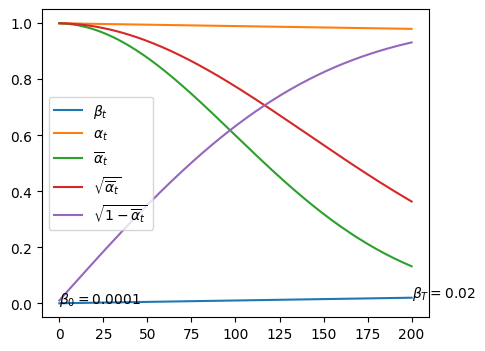

In [315]:
def linear_noise_schedule(num_steps=200, beta_0=0.0001, beta_T=0.02):
    betas = torch.linspace(beta_0, beta_T, num_steps)
    return betas


def plot_betas_alphas(betas):
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas,0)
    num_steps = len(betas)
    
    ts = torch.linspace(0, num_steps, num_steps)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(ts[-len(betas):], betas, label=r'$\beta_t$')
    ax.plot(ts, alphas, label=r'$\alpha_t$')
    ax.plot(ts[:len(alpha_bars)], alpha_bars, label=r'$\overline{\alpha}_t$')
    ax.plot(ts[:len(alpha_bars)], torch.sqrt(alpha_bars), label=r'$\sqrt{\overline{\alpha}_t}$')
    ax.plot(ts, torch.sqrt(1-alpha_bars), label=r'$\sqrt{1-\overline{\alpha}_t}$')
    beta_0, beta_T = betas[0], betas[-1]
    ax.text(0,  beta_0, r'$\beta_0 = $'+f'{beta_0:.4f}')
    ax.text(ts[-1],  beta_T, r'$\beta_T = $'+f'{beta_T:.2f}')
    ax.legend()
    plt.plot()

betas = linear_noise_schedule()
plot_betas_alphas(betas) 

The red and purple lines are the "cross-fade" coefficients for the image signal and the noise, respectively. If they look a bit "off" or "wonky" to you, you've got good intuition. (You might want to skip down to the "cosine schedule" toward the end of this notebook to see hope OpenAI fixed the wonkiness.) 

## 2.3 Model Code

In [231]:
# instead of nn.Module, we use L.LightningModule
class DDPMModule(L.LightningModule):
    def __init__(self, unet, max_steps=1000):
        super().__init__()
        self.model = unet
        self.max_steps = max_steps
        self.steps = max_steps
        self.betas = linear_noise_schedule(max_steps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas,0)
        self.sqrt_1malpha_bars = torch.sqrt(1.0 - self.alpha_bars)
        
    def forward(self, x, noise_level, labels=None):
        return self.model(x, noise_level, labels)

    def add_noise(self, x0, eps, timesteps):
        # timesteps (bs)
        s1 = self.alpha_bars[timesteps] # bs
        s2 = self.sqrt_1malpha_bars[timesteps] # bs
        s1 = s1.reshape(-1,1,1,1) # (bs, 1, 1, 1) for broadcasting
        s2 = s2.reshape(-1,1,1,1) # (bs, 1, 1, 1)
        return s1 * x0 + s2 * eps
    
    def training_step(self, batch, batch_idx):
        x0, y = batch
        #x0 = x0.view(x0.size(0), -1)  # flatten for linear layer
        if self.alpha_bars.device != x0.device: self.alpha_bars = self.alpha_bars.to(x0.device) 
        if self.sqrt_1malpha_bars.device != x0.device: self.sqrt_1malpha_bars = self.sqrt_1malpha_bars.to(x0.device) 

        #give it a bunch of different times throughout the batch
        timesteps = torch.randint(0, self.max_steps, (x0.shape[0],)).long().to(x0.device)
        
        # add a bit of noise
        t_i = torch.randint(len(self.alpha_bars), (1,)).item() # random index of noise sched
        alpha_bar_t = self.alpha_bars[timesteps]
        eps = torch.randn_like(x0)  # noise that what we're gonna add
        #input = torch.sqrt(alpha_bar_t)* x0 + torch.sqrt(1.0 - alpha_bar_t)*eps  # here's the noise adding part
        input = self.add_noise(x0, eps, timesteps)
        
        #nl_cond = alpha_bar_t + torch.zeros([alpha_bar_t]).to(x0.device)        
        nl_cond = timesteps
        
        eps_pred = self.forward(input, nl_cond)                       # try to predict the added noise

        loss = F.mse_loss(eps_pred, eps) # target is the noise added          

        self.log('loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


ddpm = DDPMModule(unet)

## Training

In [232]:
use_wandb = False
if use_wandb:
    wandb.finish()
    wandb_logger = WandbLogger(log_model="all", project='ddpm_tut')
    try:
        wandb_logger.watch(model) 
    except:
        pass

In [233]:
epochs = 150 # you could stop at 50 but more is better
if use_wandb:
    trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger)
    trainer.fit(model=ddpm, train_dataloaders=train_dl, val_dataloaders=val_dl )
    wandb.finish()
else:
    trainer = L.Trainer(max_epochs=epochs, devices="auto")#, logger=wandb_logger)
    trainer.fit(model=ddpm, train_dataloaders=train_dl, val_dataloaders=val_dl )
    

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shawley/envs/dlaie/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params
-------------------------------------
0 | model | MyTinyUNet | 537 K 
-------------------------------------
437 K     Trainable params
100 K     Non-trainable params
537 K     Total params
2.150     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


## Inference

In [339]:
@torch.no_grad()
def sample(module, model, batch_size=16, labels=None, cfg_scale=0.0): # labels & cfg_scale come later in the lesson
    model.eval()
    device = module.device
    model = model.to(device)
    x = torch.randn(batch_size, 1, imsize, imsize).to(device)
    if labels is not None: labels = labels.to(device)

    alphas = module.alphas.to(device)
    alpha_bars = module.alpha_bars.to(device)
    first_coeff = 1.0/alphas ** 0.5
    eps_coeff = (1.0-alphas)/module.sqrt_1malpha_bars.to(device)
    print("eps_coeff[0] = ",eps_coeff[0])
    timesteps = list(range(len(module.betas)))[::-1]  # we go backwards in time
    sqrt_betas = torch.sqrt(module.betas).to(device)
    
    for i, t in enumerate(tqdm(timesteps)): 
        first_coeff_t = first_coeff[i].reshape(-1,1,1,1)
        eps_coeff_t = eps_coeff[i].reshape(-1,1,1,1)
        nl_cond = (torch.ones(batch_size,1) * t).long().to(device) # noise level conditioning
        eps_pred = model(x, nl_cond, labels)                        # predict noise to remove
        if cfg_scale > 0.0:
            eps_pred_uncond = model(x, nl_cond, labels=None)
            eps_pred = torch.lerp(eps_pred_uncond, eps_pred, cfg_scale)
        x = first_coeff_t * ( x - eps_coeff_t*eps_pred )    # remove the noise
        if i > 0:  
            x = x + sqrt_betas[i]*torch.rand_like(x)
    model.train()
    return x.cpu()


def demo(module, model, nrows=10, ncols=10, labels=None, cfg_scale=0.0, use_grid=True):
    batch_size = nrows*ncols
    x = sample(module, model, batch_size=batch_size, labels=labels)
    
    #rescale to clean up
    rescale = True
    if rescale:
        x = x.view(batch_size,-1)
        x = x - torch.min(x,dim=1,keepdim=True)[0]
        x =  x / torch.max(x,dim=1, keepdim=True)[0]
        x = x.view(-1,imsize,imsize)
    
    if use_grid:
        x = x.unsqueeze(1)
        fig, ax = plt.subplots(figsize=(5,5))
        grid = torchvision.utils.make_grid(x, nrows)
        grid = rearrange(grid, 'c h w -> h w c') 
        ax.imshow(grid.numpy())
        plt.axis('off')
    else:
        fig, axs = plt.subplots(figsize=(5,5),nrows=nrows, ncols=ncols, sharex=True, sharey=True)
        ax = axs.ravel()
        for i in range(batch_size):
            img = x[i]
            if len(img.shape) > 2: img = img[0] # remove spurious color channel
            pane = ax[i].imshow(img.numpy())
            #ax[i].axis('off')
        cbar_ax = fig.add_axes([0.95, 0.11, 0.05, 0.77])
        fig.colorbar(pane, cax=cbar_ax)
    plt.show()
    return

  0%|          | 0/1000 [00:00<?, ?it/s]

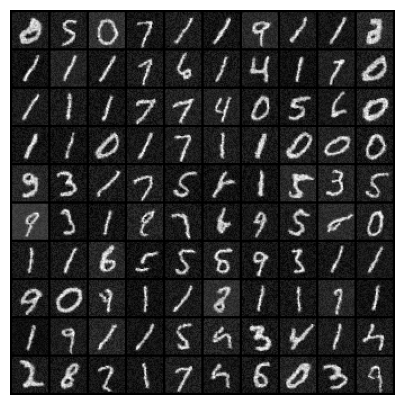

In [241]:
demo(ddpm, ddpm.model)

Note: if you go back and train for longer, you'll get better images than what you see above. For example, after a while I got these:

![digits looking good](../images/digits_yay.png)

# 6. Enhancements

We're going to add a control so we can specify which digit we want, and make a couple improvements to the model.  

## 6.1. Guidance (/ "Classifier Guidance") 
One way to do this is via "classifier guidance" by hookin up a (pretrained) classifier model to look at the output of the diffusion model and give feedback in the form of gradients. The cool thing about this is that *we don't need to alter the diffusion model in any way*: guidance happens during Sampling! Thus you can think of guidance as a "plug-in" that you attach to any existing diffusion model!  You can use other signal other thank a classifier, such a text-image matcher like CLIP. So-called "CLIP guidance" can be handy. 

...uh... but I want to skip that for now and move on to a topic that's caught on even more...


## 6.2 Classifier-Free "Guidance," aka Conditioning...Sometimes

> Reference: [Classifier-Free Guidance Paper](https://arxiv.org/pdf/2207.12598.pdf#page=5) by Ho & Salimans, 2022 (same Ho as DDPM), see p.5
 
This isn't the kind of guidance like we just talked about, even though the name "guidance" is still used. (Sorry, I don't make up the lingo.) This is not a plug-in for existing models, this involves training a new model.  In "Classifier-Free Guidance" we *condition* the diffusion model like we would any other model -- i.e., we attach extra inputs to the model that are enforced during (new) training -- except that half the time we're training, we *turn off* the guidance signal and let the model generate in an unconditioned mode (i.e., like we did above, where you never know what kind of image you'll get). 

Turns out that this gives the system a good balance between conditional control and generative variety. And there's only a tiny bit more math to make it work. Here comes the math. We'll represent the input to the model as $z$ and model by ${\bf \epsilon}_\theta(z)$ (i.e. it predicts the noise $\epsilon$ using the model parameters $\theta$ given $z$), and represent the conditioning as ${\bf c}$ and the "conditioning strength" by $w$. Using those symbols, the revised "classifier-free guidance" version's model prediction $\tilde{{\bf \epsilon}}_\theta(z)$ is the following linear combination of the condioned model output and the unconditioned model output: 

$$     \tilde{{\bf \epsilon}}_\theta({\bf z}, {\bf c}) = (1+w){\bf \epsilon}_\theta({\bf z}, {\bf c}) - w{\bf \epsilon}_{\theta}({\bf z})$$

And given that our U-Net already has time-conditioning built in, and the heart of the diffusion model is the U-Net.... 
I already made the U-Net code above ready to handle conditioning.

## 6.3 EMA Weights
We're going to keep an exponentially moving average (EMA) of our model weights, which won't affect our training but which may make inference a bit better. 

## 6.4 New Improved Code (CFG + EMA)

In [266]:
from copy import deepcopy 

class EMA:
    def __init__(self, eta):
        self.eta = eta
        self.step = 0

    def step_ema(self, ema_model, model, warmup_steps=500):
        self.step += 1
        if self.step < warmup_steps:
            ema_model.load_state_dict(model.state_dict())  # no ema yet, just copy
        else:
            for new_param, ema_param in zip(model.parameters(), ema_model.parameters()):
                ema_param.data = self.eta*ema_param.data + (1.0-self.eta)*new_param.data


class DDPMCond(L.LightningModule):
    def __init__(self, max_steps=1000,  n_classes=10, eta_ema=.995, noise_sched='linear'):
        super().__init__()
        self.unet = MyTinyUNet(n_classes=n_classes)
        self.model = self.unet
        self.max_steps = max_steps
        
        if 'cos' in noise_sched:
            self.betas = cosine_noise_schedule(max_steps)
        else: 
            self.betas = linear_noise_schedule(max_steps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas,0)
        self.sqrt_1malpha_bars = torch.sqrt(1.0 - self.alpha_bars)
        
        self.ema = EMA(eta_ema)
        self.ema_model = deepcopy(self.model).eval().requires_grad_(False)
        
    def forward(self, x, noise_level, labels=None):
        return self.unet(x, noise_level, labels=labels)

    def add_noise(self, x0, eps, timesteps):
        # timesteps (bs)
        s1 = self.alpha_bars[timesteps] # bs
        s2 = self.sqrt_1malpha_bars[timesteps] # bs
        s1 = s1.reshape(-1,1,1,1) # (bs, 1, 1, 1) for broadcasting
        s2 = s2.reshape(-1,1,1,1) # (bs, 1, 1, 1)
        return s1 * x0 + s2 * eps
    
    def training_step(self, batch, batch_idx):
        x0, y = batch
        if self.alpha_bars.device != x0.device: self.alpha_bars = self.alpha_bars.to(x0.device) 
        if self.sqrt_1malpha_bars.device != x0.device: self.sqrt_1malpha_bars = self.sqrt_1malpha_bars.to(x0.device) 

        #give it a bunch of different times throughout the batch
        timesteps = torch.randint(0, self.max_steps, (x0.shape[0],)).long().to(x0.device)
        
        # add a bit of noise
        t_i = torch.randint(len(self.alpha_bars), (1,)).item() # random index of noise sched
        alpha_bar_t = self.alpha_bars[timesteps]
        eps = torch.randn_like(x0)  # noise that what we're gonna add
        input = self.add_noise(x0, eps, timesteps)

        # conditioning
        nl_cond = timesteps # on time
        if np.random.rand() < 0.1: 
            y = None  # for cfg
        
        eps_pred = self.forward(input, nl_cond, labels=y)                       # try to predict the added noise

        loss = F.mse_loss(eps_pred, eps) # target is the noise added          

        self.log('loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=5e-4)

    def on_before_zero_grad(self, *args, **kwargs):
        self.ema.step_ema(self.ema_model, self.model)
    
ddpm_c = DDPMCond()

In [267]:
max_epochs = 150
trainer = L.Trainer(max_epochs=max_epochs, devices="auto")
trainer.fit(model=ddpm_c, train_dataloaders=train_dl)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type       | Params
-----------------------------------------
0 | unet      | MyTinyUNet | 538 K 
1 | ema_model | MyTinyUNet | 538 K 
-----------------------------------------
438 K     Trainable params
638 K     Non-trainable params
1.1 M     Total params
4.308     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


regular weights:


  0%|          | 0/1000 [00:00<?, ?it/s]

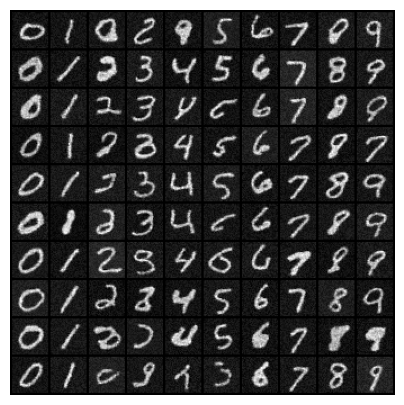

In [281]:
labels = torch.tensor([0,1,2,3,4,5,6,7,8,9]*10).long().unsqueeze(-1).to(ddpmc.device)
print("regular weights:")
demo(ddpm_c, ddpm_c.model, labels=labels, cfg_scale=4, use_grid=True)

ema weights:


  0%|          | 0/1000 [00:00<?, ?it/s]

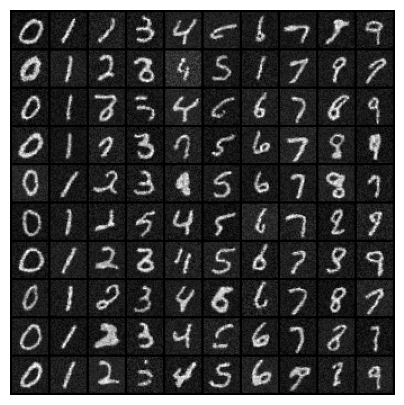

In [282]:
print("ema weights:")
demo(ddpm_c, ddpm_c.ema_model, labels=labels, cfg_scale=4, use_grid=True)

....not sure that the EMA version is much better than the non-ema version. Maybe a little better.

## 6.5 Cosine Noise Schedule
We can get comparable results to before using fewer sampling steps, if we adjust the noise schedule.  Instead of a linear slope for the $\beta_t$ values, we'll use a cosine shape for $\overline{\alpha_t}$, and derive $\beta_t$ from that.   Source: [OpenAI paper, page 4](https://arxiv.org/pdf/2102.09672.pdf#page=4)

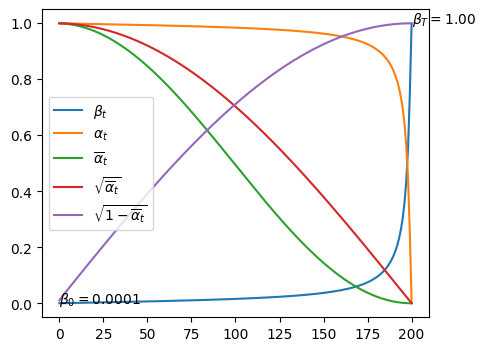

In [285]:
def cosine_noise_schedule(max_steps, s=0.008):  # s0 value in OpenAI paper
    times = torch.arange(max_steps)
    t, T = times.float(), times[-1].float()
    f = torch.cos( (t/T + s)/(1+s) *torch.pi*0.5 )**2
    alpha_bars = f/f[0]
    betas = 1.0 - alpha_bars[1:]/alpha_bars[:-1]       # this loses us a time step, folks. nobody seems to mind this
    #beta_0 = 1 - alpha_bars[0]                        # because at t=0, alpha_bars[0] = alphas[0] = 1-betas[0]
    beta_0 = 0.0001 # because it's what DDPM used? 
    betas = torch.cat((torch.tensor([beta_0]),betas))  # my hack to get one missing time step back
    betas = torch.clamp(betas , 0.00, 0.999)
    return betas

betas = cosine_noise_schedule(200)
plot_betas_alphas(betas)  # use our grapher from before

The red (image strength) and purple (noise strength) lines above look *just* like what you see in a DAW when you cross-fade on the basis of constant *power* rather than *amplitude*. In fact, the point where they cross looks like the famous 0.707 that appears with RMS values... Let's check! 

In [293]:
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas,0)
torch.sqrt(alpha_bars)[len(betas)//2-1]  # if this equals 0.707 then we know we're cross-fading noise power...

tensor(0.7055)

...yea, close enough!

Retraining with this noise schedule, let's see what we get...

In [296]:
ddpm_cs = DDPMCond(noise_sched='cos', max_steps=200)
max_epochs = 200
trainer = L.Trainer(max_epochs=max_epochs, devices="auto")
trainer.fit(model=ddpm_cs, train_dataloaders=train_dl)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type       | Params
-----------------------------------------
0 | unet      | MyTinyUNet | 538 K 
1 | ema_model | MyTinyUNet | 538 K 
-----------------------------------------
438 K     Trainable params
638 K     Non-trainable params
1.1 M     Total params
4.308     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


So below we'll be using one-tenth as many steps as we used to need. Let's see what we get!

eps_coeff[0] =  tensor(0.0100)


  0%|          | 0/200 [00:00<?, ?it/s]

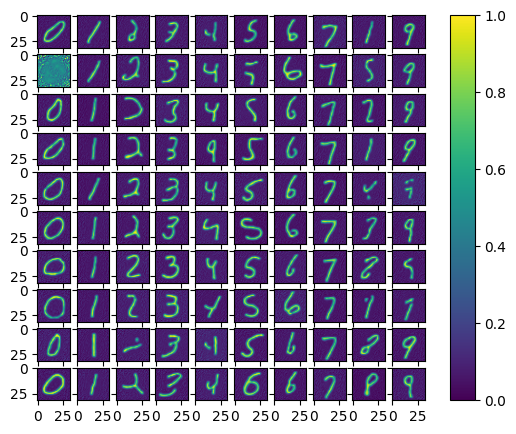

In [340]:
demo(ddpm_cs, ddpm_cs.ema_model, labels=labels, cfg_scale=8, use_grid=False)

TODO: ...Yea I don't feel like I have a handle on the cosine schedule just yet.

...stopping here for now. 

In [330]:
module = ddpm_c
alphas = module.alphas.cpu()
alpha_bars = module.alpha_bars.cpu()
first_coeff = 1.0/alphas ** 0.5
eps_coeff = (1.0-alphas)/module.sqrt_1malpha_bars.cpu()


In [337]:
1-alphas[0]

tensor(0.0001)

In [335]:
module.sqrt_1malpha_bars.cpu()[0]

tensor(0.0100)